# Solve frozen lake with Q-network

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

Solve the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment using on-policy neural Q-learning with epsilon-greedy action selection.

This approach employs a Q-function which can be updated using bootstrapping:

$$
Q(s,a;\theta) \leftarrow Q(s,a;\theta) + \alpha \delta \ ,
$$

where $\delta = r + \gamma \max_{a'} Q(s',a';\theta) - Q(s,a;\theta)$ is the TD error.

Since we use a neural network to represent $Q$, we cannot do this assignment directly, but instead perform a gradient update using squared loss: 

$$
L(\theta) = \delta^2 \ ,
$$

with transitions $(s,a,r,s')$ sampled from the environment. 

Algorithm:

1. Do a forward pass for current state, $s$, to get predicted Q-values for all actions.
2. Select an action, $a$, with epsilon-greedy strategy and execute it to observe a reward and next state, $r,s'$.
3. Do a forward pass for the next state, $s'$.
4. Set Q-target for action $a$ to $r + \gamma \max_{a'} Q(s',a';\theta)$ and to the Q-values from step 1 for all other actions, making the TD error zero for those outputs.
5. Update network weights with backpropagation.
6. Set $s\leftarrow s'$ and repeat.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym

In [2]:
env = gym.make('FrozenLake-v0')

In [3]:
# show init state
s = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [4]:
class QNetwork(nn.Module):
    """Q-network"""

    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(QNetwork, self).__init__()
        # network
        self.out = nn.Linear(n_inputs, n_outputs, bias=False)
        torch.nn.init.uniform_(self.out.weight, 0, 0.01)
        # training
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate)

    def forward(self, x):
        return self.out(x)
    
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))

In [5]:
def one_hot(i, l):
    """One-hot encoder for the states"""
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

In [11]:
# train Q-network

num_episodes = 1000
episode_limit = 100
learning_rate = 0.1
gamma = 1.00 # discount rate
val_freq = 100 # validation frequency

n_inputs = env.observation_space.n
n_outputs = env.action_space.n

qnet = QNetwork(n_inputs, n_outputs, learning_rate)

try:
    epsilon = 1.0
    rewards, lengths, losses, epsilons = [], [], [], []
    print('start training')
    for i in range(num_episodes):
        # init new episode
        s, ep_reward, ep_loss = env.reset(), 0, 0
        for j in range(episode_limit):
            # 1. do foward pass of current state to compute Q-values for all actions
            qnet.optimizer.zero_grad()
            Q = qnet(torch.from_numpy(one_hot([s], n_inputs)).float())
            # 2. select action with epsilon-greedy strategy
            a = Q.argmax().item() if np.random.rand() > epsilon else env.action_space.sample()
            s1, r, done, _ = env.step(a)
            # 3. do forward pass for the next state
            with torch.no_grad():
                Q1 = qnet(torch.from_numpy(one_hot([s1], n_inputs)).float())
            # 4. set Q-target
            q_target = Q.clone()
            q_target[0, a] = r + gamma * Q1.max().item() * (not done)
            # 5. update network weights
            loss = qnet.loss(Q, q_target)
            loss.backward()
            qnet.optimizer.step()
            # 6. bookkeeping
            s = s1
            ep_reward += r
            ep_loss += loss.item()
            if done: break
        # bookkeeping
        epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
        epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(j+1); losses.append(ep_loss)
        if (i+1) % val_freq == 0: print('{:5d} mean training reward: {:5.2f}'.format(i+1, np.mean(rewards[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
  100 mean training reward:  0.01
  200 mean training reward:  0.02
  300 mean training reward:  0.02
  400 mean training reward:  0.05
  500 mean training reward:  0.07
  600 mean training reward:  0.31
  700 mean training reward:  0.35
  800 mean training reward:  0.38
  900 mean training reward:  0.39
 1000 mean training reward:  0.51
done


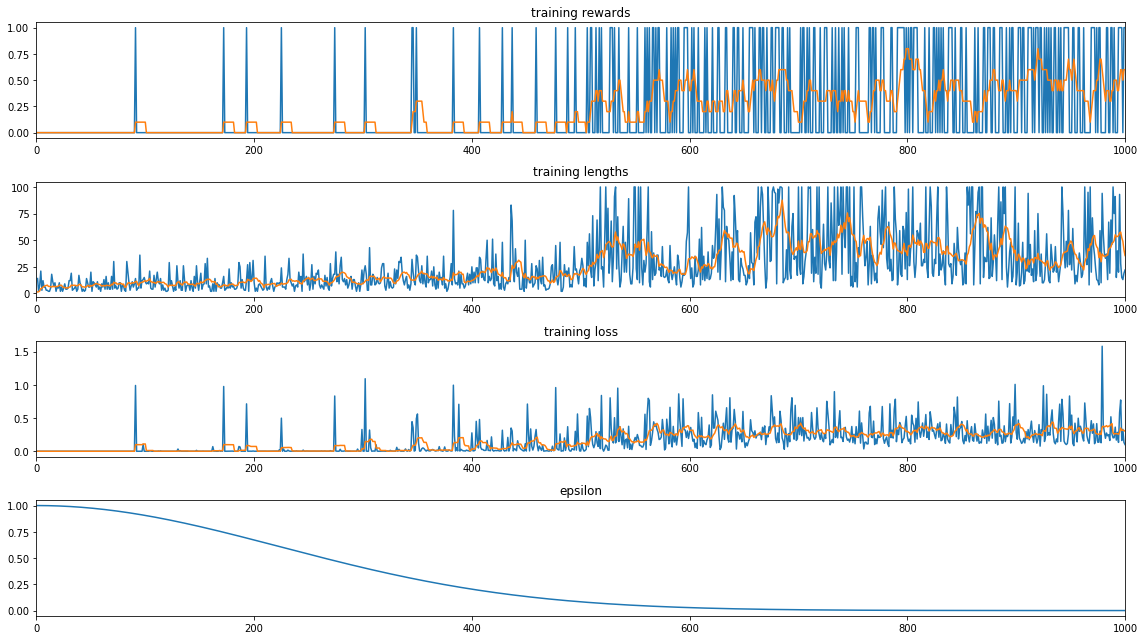

In [12]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(range(1, num_episodes+1), moving_average(rewards))
plt.xlim([0, num_episodes])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])
plt.tight_layout(); plt.show()